In [1]:
import utils

points, colors = utils.las2npy("../../dataset/001-010.las")
points = points[::100]
colors = colors[::100]
voxel_size = 0.1
voxels, idx_o2n, idx_n2o, unique_counts = utils.voxel_downsample(points, voxel_size, True)
colors = colors[idx_o2n]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
start_point = 0
march_step = 10000
pivot_vec = []
index_vec = []

num_voxels = voxels.shape[0]
while start_point < num_voxels:
    pivot = utils.get_average_pivot(voxels[start_point:min(start_point + march_step, num_voxels), 2])
    pivot_vec.append(pivot)
    index_vec.append(start_point)
    start_point += march_step



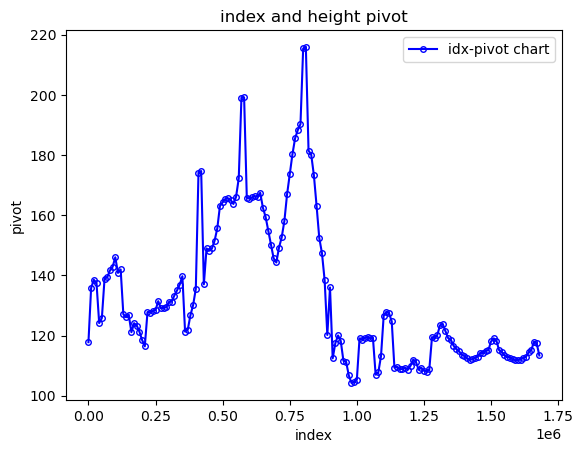

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(index_vec, pivot_vec, label="idx-pivot chart", color="blue", marker='o', markerfacecolor='none', markeredgewidth=1.0, markersize=4)

plt.title("index and height pivot")
plt.xlabel("index")
plt.ylabel("pivot")
plt.legend()

plt.show()

In [4]:
import numpy as np

selection_vec = np.empty(0, dtype=bool)
num_voxels = voxels.shape[0]
for index, pivot in zip(index_vec, pivot_vec):
    # print(voxels[index:index + march_step, 2] < pivot)
    selection_vec = np.concatenate((selection_vec, voxels[index:min(num_voxels, index + march_step), 2] > pivot))

In [5]:
voxels_filtered = voxels[selection_vec]
colors_filtered = colors[selection_vec]
utils.npy2ply(voxels_filtered, colors_filtered, "./data/filtered_sample.ply")

In [6]:
voxels_filtered = voxels_filtered[:int(1e5)]
colors_filtered = colors_filtered[:int(1e5)]
eigen_mat, neighbour_num_record = utils.eigval_radius(voxels_filtered, voxel_size * 55.0)

eigval progress: 100%|████████████████████████████████████| 100000/100000 [00:19<00:00, 5165.53it/s]


In [7]:
eigen_max = np.max(eigen_mat, axis=0)
eigen_min = np.min(eigen_mat, axis=0)
eigen_mat = (eigen_mat - eigen_min) / eigen_max * 255.0
eigen_mat = eigen_mat.astype(np.int32)

In [8]:
utils.npy2ply(voxels_filtered, eigen_mat, "./data/filtered_sample.ply")

In [9]:
powerline_selection = (eigen_mat[:, 0] > 50) & (eigen_mat[:, 1] < 50)

powerline_voxels = voxels_filtered[powerline_selection]
powerline_colors = eigen_mat[powerline_selection]

utils.npy2ply(powerline_voxels, powerline_colors, "./data/powerline.ply")

In [10]:
ground_selection = eigen_mat[:, 1] > 50
ground_voxels = voxels_filtered[ground_selection]
ground_colors = eigen_mat[ground_selection]

In [11]:
# now ground still include the tower, use a wider radius to
# generate new eigen values depiction
feat_mat, neighbour_num_record = utils.eigval_vertic(ground_voxels, voxel_size * 50.0)

eigval progress: 100%|██████████████████████████████████████| 83136/83136 [00:42<00:00, 1950.62it/s]


In [12]:
feat_max = np.max(feat_mat, axis=0)
feat_min = np.min(feat_mat, axis=0)
feat_mat = (feat_mat - eigen_min) / feat_max * 255.0
feat_mat = feat_mat.astype(np.int32)

In [58]:
half_max_height = np.median(feat_mat[:, 1])
tower_selection = (feat_mat[:, 0] > 100) & \
                  (feat_mat[:, 1] > half_max_height) & \
                  (feat_mat[:, 2] < 25)
tower_voxels = ground_voxels[tower_selection]
tower_colors = feat_mat[tower_selection]
utils.npy2ply(tower_voxels, tower_colors, "./data/tower.ply")

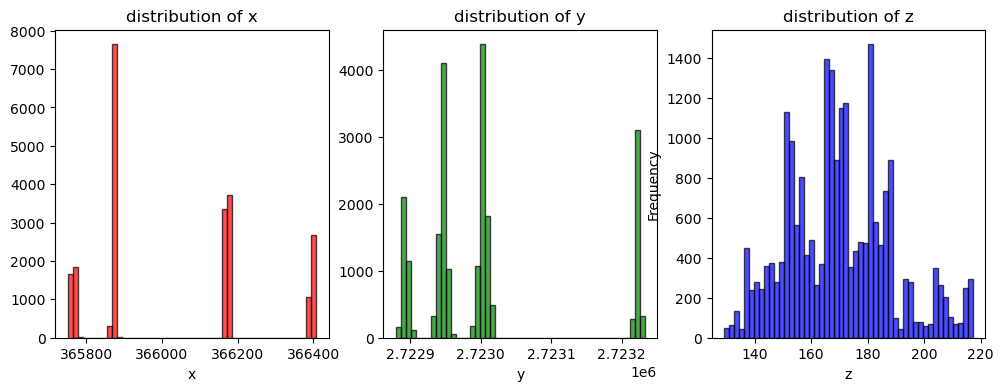

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(tower_voxels[:, 0], bins=50, color="red", edgecolor='black', alpha=0.7)
plt.title('distribution of x')
plt.xlabel('x')

plt.subplot(1, 3, 2)
plt.hist(tower_voxels[:, 1], bins=50, color="green", edgecolor='black', alpha=0.7)
plt.title('distribution of y')
plt.xlabel('y')

plt.subplot(1, 3, 3)
plt.hist(tower_voxels[:, 2], bins=50, color="blue", edgecolor='black', alpha=0.7)
plt.title('distribution of z')
plt.xlabel('z')

plt.ylabel('Frequency')
# Display the histogram
plt.show()

In [60]:
labels = np.array(utils.npy2o3d(tower_voxels).cluster_dbscan(eps=voxel_size * 50.0, min_points=100, print_progress=False))
print(f"clustered number: {labels.max() + 1}")
unique_labels, labels_count = np.unique(labels, return_counts=True)
print(dict(zip(unique_labels, labels_count)))
print(labels_count.mean())

unique_labels = unique_labels[1:]
labels_count = labels_count[1:]

label_selection = labels_count > (labels_count.mean() / 2.0)

valid_labels = unique_labels[label_selection]


valid_instance_selection = np.zeros((0,), dtype=bool)
for label_idx in valid_labels:
    tower_instance_selection = (labels == label_idx)
    tower_colors[tower_instance_selection] = np.array([
        np.random.randint(100, 255),
        np.random.randint(100, 255),
        np.random.randint(100, 255)
    ])

# get rid of noise points
noise_filtered_selection = (labels >= 0) & (labesl != )
tower_voxels_denoised = tower_voxels[noise_filtered_selection]
tower_colors_denoised = tower_colors[noise_filtered_selection]

utils.npy2ply(tower_voxels_denoised, tower_colors_denoised, "./data/tower.ply")

clustered number: 5
{-1: 261, 0: 3449, 1: 7940, 2: 7072, 3: 342, 4: 3232}
3716.0
